# Max Flow Applications

The purpose of this assignment is to investigate applications of finding a Max Flow. The problem asks you to design and implement an algorithm for shipping a material between nodes with different supply and demand requirements.

* Please write code *only* in the bodies of the two functions, that is, following the TODO comments.
* Be careful not to use varibles defined outside of the functions.
* Breaking the two above rules may lead to 0 grades.

## Movie distribution

First solve Problem 2 from hw3-t. 

Now suppose a movie distributor would like to ship a copy of a film from CA to every other state. There are therefore 48 units to ship out of CA, and each other state receives 1 unit. 

The dataset contiguous-usa.dat lists the adjacent states in the US. Each line lists two adjacent states; thus AK and HI are omitted, but DC is included in the data. The following code reads in the graph of US states.

In [1]:
import networkx as nx
G = nx.Graph()

usa = open('contiguous-usa.dat')
for line in usa:
    s1, s2 = line.strip().split()
    G.add_edge(s1, s2)

We now encode the demands into the graph.

In [2]:
for state in G.nodes():
    if state != 'CA':
        G.node[state]['demand'] = 1
G.node['CA']['demand'] = -48

We will assign a uniform capacity of 16 to each edge. Since CA has only three adjacent states, this is the smallest possible uniform capacity that allows one to ship all 48 units out of CA. As we have created an undirected graph, and flows have directions, we first convert the graph to a directed graph.

In [3]:
G = nx.DiGraph(G)
uniform_capacity = 16
for (s1, s2) in G.edges():
    G.edge[s1][s2]['capacity'] = uniform_capacity

Complete the following function to implement your algorithm to find a flow with demands. Your function should work correctly for any input, not just the movie instance considered here. As always, you are encouraged to define auxiliary functions as needed for clarity.

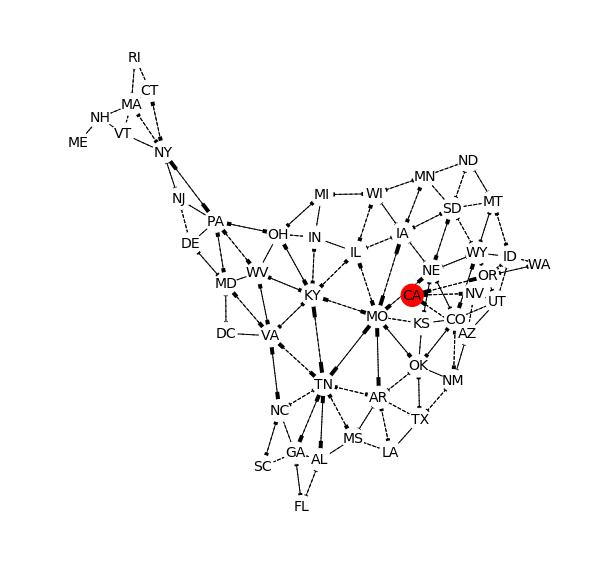

In [98]:
# REMOVE ME
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graph(G):
    plt.figure(figsize=(10,10))
    nodes_to_dist = nx.single_source_shortest_path_length(G,'CA')
    inverted = ((v, k) for k, v in nodes_to_dist.iteritems())
    def upsert(d, (k,v)):
        if k in d:
            l = d[k]
            l.append(v)
            d.update({k : l})  
        else: 
            d.update({k : [v]})
        return d
    inverted_dict = reduce(upsert, inverted, {})
    shells = [inverted_dict[k] for k in sorted(inverted_dict.keys())]
    #print(inverted_dict)
    #print(shells)
    pos=nx.shell_layout(G, shells) # positions for all nodes
    
    #pos=nx.spring_layout(G) # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=1, style='dashed')
    #nx.draw_networkx_edges(G,pos,edgelist=G.edges(data=True), width=6, alpha=0.5, edge_color='b', style='dashed')

    # labels
    nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')

    plt.axis('off')
    #plt.savefig("weighted_graph.png") # save as png
    plt.show() # display

def spring_plot(G):
    plt.figure(figsize=(10,10))
    initial_pos = {'CA': (0.01,0.01)}
    pos=nx.spring_layout(G, iterations=300, fixed=initial_pos.keys(), k=0.05)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=['r' if n == 'CA' else 'w' for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=1, style='dashed')
    #sp = nx.shortest_path(G, 'CA', 'ME')
    #pairs = [(u,v) for u, v in zip(sp[:-1], sp[1:])]
    #nx.draw_networkx_edges(G, pos, edgelist=pairs, width=2, edge_color='b', style='solid')
    nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')
    plt.axis('off')
    plt.show()
    
def flow_to_graph(flow):
    g = nx.Graph()
    for u, vs in flow.iteritems():
        for v, f in vs.iteritems():
            g.add_edge(u, v, capacity=f)
    return g
spring_plot(G)

In [138]:
def flow_with_demands(graph):
    """Computes a flow with demands over the given graph.
    
    Args:
        graph: A directed graph with nodes annotated with 'demand' properties and edges annotated with 'capacity' 
            properties.
        
    Returns:
        A dict of dicts containing the flow on each edge. For instance, flow[s1][s2] should provide the flow along
        edge (s1, s2).
        
    Raises:
        NetworkXUnfeasible: An error is thrown if there is no flow satisfying the demands.
    """
    def add_source_and_sink(orig_graph):
        graph = orig_graph.copy()
        s = 's_long_name_not_to_conflict_with_any_preexisting_node'
        t = 't_long_name_not_to_conflict_with_any_preexisting_node'
        for node, props in graph.nodes(data=True):
            if props['demand'] < 0:
                graph.add_edge(s, node, capacity=abs(props['demand']))
            elif props['demand'] > 0:
                graph.add_edge(node, t, capacity=props['demand'])
        return graph, s, t
    
    def remove_source_and_sink_from_flow(flow, s, t):
        def without(d, keys):
            return { u:d[u] for u in d if not u in keys }
        return {k:without(flow[k], [s,t]) for k in without(flow, [s,t])}
    
    def full_capacity_from_source(g, s):
        return sum([props['capacity'] for _, _, props in g.edges(s, data=True)])
    
    augmented_G, s, t = add_source_and_sink(graph)
    flow_value, flow_dict = nx.maximum_flow(augmented_G, s, t)
    if flow_value < full_demand_capacity(augmented_G, s):
        raise nx.NetworkXUnfeasible("There is no flow satisfying the demands")
    return remove_source_and_sink_from_flow(flow_dict, s, t)
    
flow_with_demands(G)


(48, 49)


NetworkXUnfeasible: There is no flow satisfying the demands

To verify that your solution is correct, implement a function that computes the total flow into each node (which will be negative for supply nodes).

In [126]:
def divergence(flow):
    """Computes the total flow into each node according to the given flow dict.
    
    Args:
        flow: the flow dict recording flow between nodes.
        
    Returns:
        A dict of the net flow into each node.
    """
    # Assumption: flow keys should be a set of all nodes.
    div = {node:0 for node in flow.keys()}
    for u, neighbors in flow.iteritems():
        for v, f in neighbors.iteritems():
            div[u] = div[u] - f
            div[v] = div[v] + f
    
    #print(div)
    return div
    

The following code performs a sanity check on your function (but does not completely confirm correctness).

In [127]:
flow = flow_with_demands(G)
div = divergence(flow)
print "Flow satisfies all demands:", all(div[n] == G.node[n]['demand'] for n in G.nodes())

Flow satisfies all demands: True
